In [11]:
import sys
sys.path.append("..")

from pathlib import Path

import numpy as np
import PIL
import torchvision
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import albumentations.augmentations.functional as F
from IPython.display import Image

from imet.dataset import load_image

In [2]:
df_test = pd.read_csv('../data/sample_submission.csv')

In [4]:
from albumentations import *
from albumentations.pytorch.transforms import ToTensor

train_transform_crop = Compose([
    RandomScale(scale_limit=0.125),
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    Rotate(limit=20,  border_mode=cv2.BORDER_REFLECT_101, p=1.),
    OneOf([
        RandomCrop(256, 256, p=0.9),
        CenterCrop(256, 256, p=0.1),
    ], p=1.)
])

tensor_transform = ToTensor(normalize=dict(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
class RandomCropIfNeeded(RandomCrop):
    """Take from:
    https://www.kaggle.com/c/imet-2019-fgvc6/discussion/94687
    """
    def __init__(self, height, width, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.height = height
        self.width = width

    def apply(self, img, h_start=0, w_start=0, **params):
        h, w, _ = img.shape
        return F.random_crop(img, min(self.height, h), min(self.width, w), h_start, w_start)

In [7]:
size = 320
train_transform_resize = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomBrightness(0.1, p=1),
        RandomContrast(0.1, p=1),
    ], p=0.3),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0,
                     rotate_limit=15, p=0.3),
    IAAAdditiveGaussianNoise(p=0.3),
    RandomCropIfNeeded(size * 2, size * 2),
    Resize(size, size),
])

In [8]:
def plot_multi(func, r:int=1, c:int=1, figsize=(12,6)):
    "Call `func` for every combination of `r,c` on a subplot"
    axes = plt.subplots(r, c, figsize=figsize)[1]
    for i in range(r):
        for j in range(c): func(i,j,axes[i,j])

### Random Crop

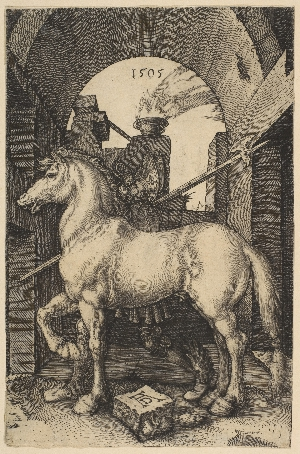

In [47]:
idx = 90
Image(filename=str(Path('../data/test/') / (df_test.iloc[idx].id + ".png")))

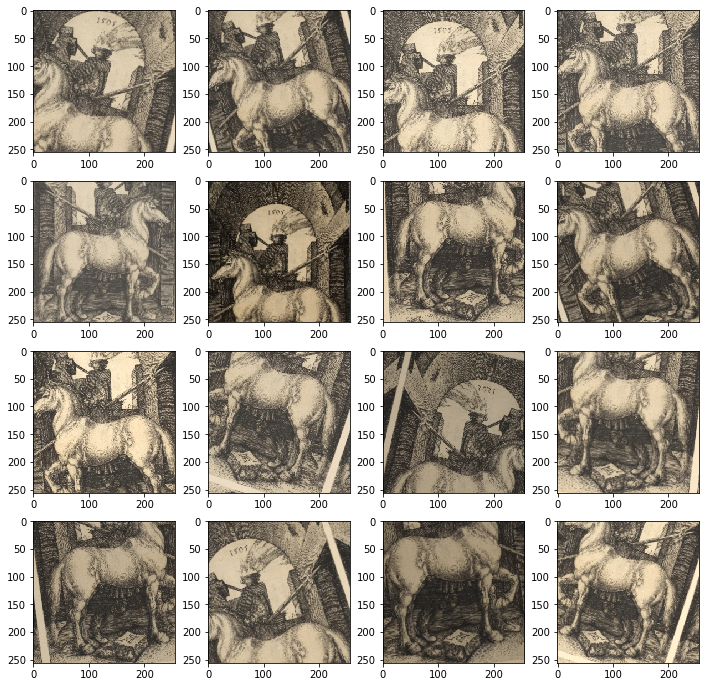

In [48]:
def _plot(i, j, ax):
    x= PIL.Image.fromarray(
        train_transform_crop(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
    )
    ax.imshow(x)
    
plot_multi(_plot, 4, 4, figsize=(12, 12))

## Resize (crop if necessary)

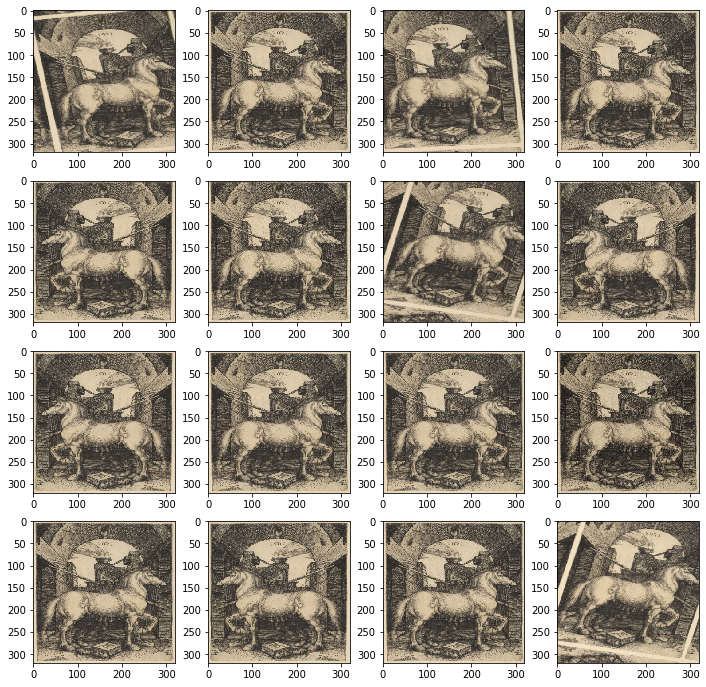

In [49]:
def _plot(i, j, ax):
    x= PIL.Image.fromarray(
        train_transform_resize(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
    )
    ax.imshow(x)
    
plot_multi(_plot, 4, 4, figsize=(12, 12))

## MixUp

Weight 0.7365710685428735


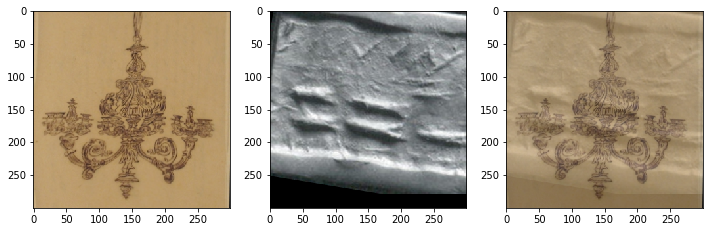

In [6]:
idx = (490, 812)
axes = plt.subplots(1, 3, figsize=(12, 4))[1]
x1 = train_transform(image=load_image(df_test.iloc[idx[0]], Path('../data/test/'),))["image"]
x2 = train_transform(image=load_image(df_test.iloc[idx[1]], Path('../data/test/'),))["image"]
axes[0].imshow(PIL.Image.fromarray(x1))
axes[1].imshow(PIL.Image.fromarray(x2))
weight = np.random.beta(1, 1)
weight = max(1-weight, weight)
print("Weight", weight)
axes[2].imshow(PIL.Image.fromarray((x1 * weight + x2 * (1-weight)).astype("uint8")))

In [7]:
" ".join(["%.4f" % x for x in np.random.beta(1, 1, 10)])

'0.3209 0.3123 0.2319 0.3004 0.1523 0.8807 0.3901 0.8712 0.2488 0.7437'

## Masking

In [10]:
idx = 201
img_arr = train_transform(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
tensor = tensor_transform(image=img_arr)["image"]
eps = 1e-3
zero_transformed = np.sum(np.array([0.485, 0.456, 0.406]) / np.array([0.229, 0.224, 0.225])) * -1
mask = (tensor.sum(dim=0, keepdim=True) >  zero_transformed + eps)

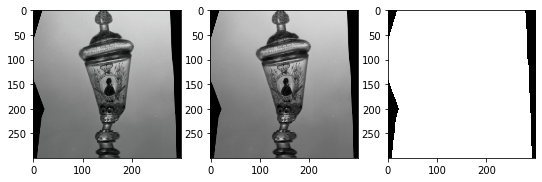

In [11]:
axes = plt.subplots(1, 3, figsize=(9,3))[1]
x= PIL.Image.fromarray(
#     train_transform(image=load_image(df_test.iloc[idx], Path('../data/test/')))["image"]
    ((tensor.numpy() * np.array([0.229, 0.224, 0.225])[:, None, None] + 
    np.array([0.485, 0.456, 0.406])[:, None, None]) * 255).astype("uint8").transpose(1, 2, 0)
)
axes[0].imshow(x)
x= PIL.Image.fromarray(
    img_arr
)
axes[1].imshow(x)
x= PIL.Image.fromarray(
    (mask.repeat(3, 1, 1).numpy() * 255).astype("uint8").transpose(1, 2, 0)
)
axes[2].imshow(x)